In [6]:
import nilearn
from nilearn import plotting
import nibabel as nb
from nilearn import image
from os import path
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

In [2]:
FMRIPREP_DIR = '/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/fmriprep'

# Rastko Fix

In [7]:
def mean_mask(masks):
    mask = nb.load(masks[0])
    hdr, aff = mask.header, mask.affine
    data = np.zeros(mask.shape)
    for mask in masks:
        data += nb.load(mask).get_data()
    data /= len(masks)
    return nb.Nifti1Image(data, aff, hdr)

In [4]:
masks = glob(path.join(FMRIPREP_DIR, 'sub-*/ses-*/func/*brain_mask.nii.gz'))

In [8]:
fixed_mask = mean_mask(masks)

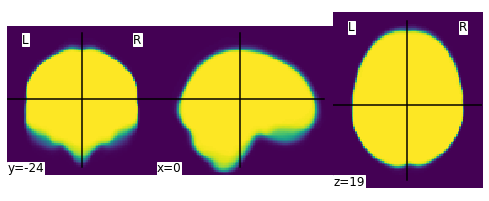

In [9]:
_ = plotting.plot_img(fixed_mask)

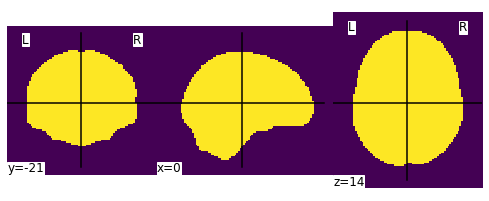

In [11]:
group_mask = image.math_img("a>=%s" % str(.95), a=fixed_mask)
_ = plotting.plot_img(group_mask)

# Individual example

In [3]:
eg_mask = path.join(FMRIPREP_DIR, 'sub-s130/ses-1/func/sub-s130_ses-1_task-DPX_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz')

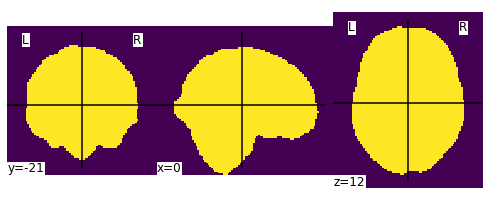

In [5]:
_ = plotting.plot_img(eg_mask)

# Using DPX masks only

In [6]:
DPX_masks = glob(path.join(FMRIPREP_DIR, 'sub-*/ses-*/func/*task-DPX*brain_mask.nii.gz'))

In [7]:
mean_mask = image.mean_img(DPX_masks)
group_mask = image.math_img("a>=%s" % str(.95), a=mean_mask)

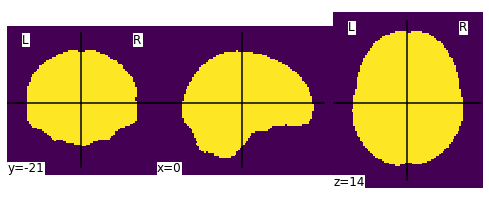

In [8]:
_ = plotting.plot_img(group_mask)

# Iterating across tasks

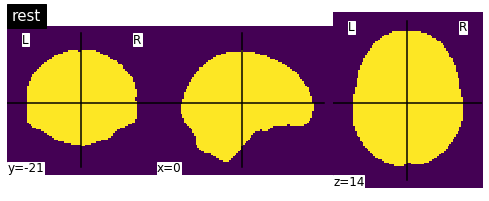

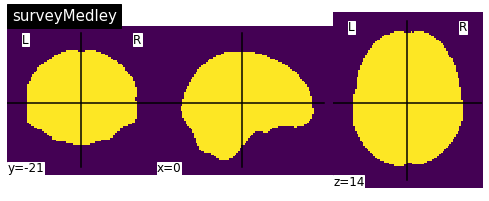

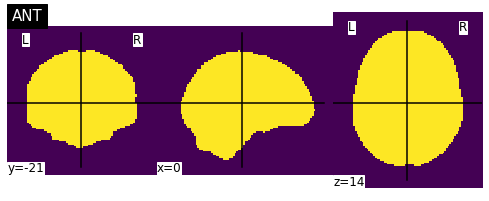

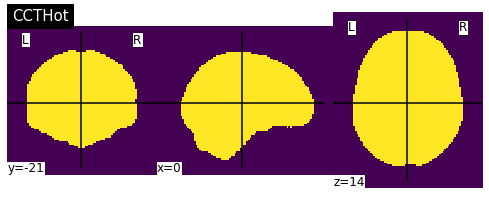

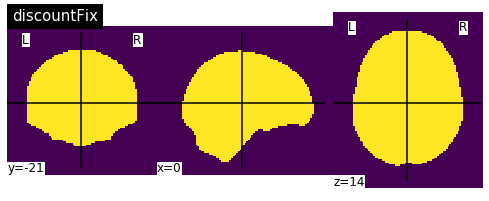

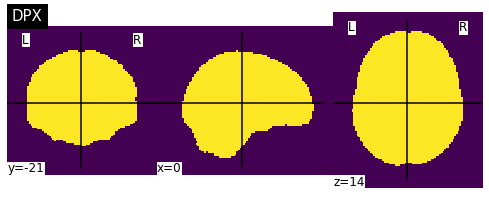

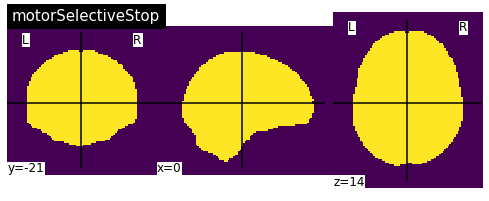

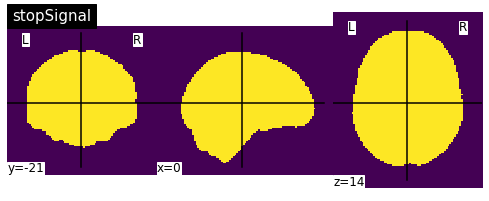

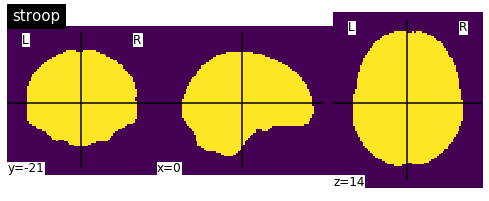

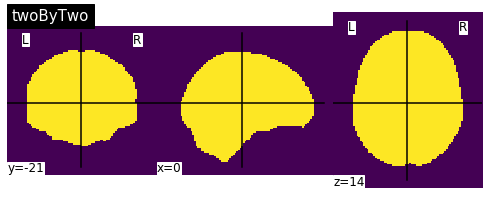

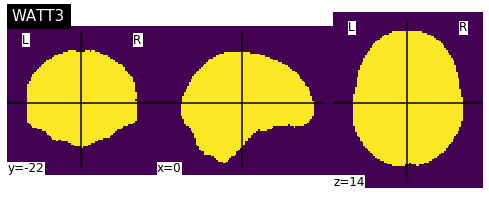

In [9]:
tasks = ['rest', 'surveyMedley', 'ANT', 'CCTHot', 'discountFix',
             'DPX', 'motorSelectiveStop',
             'stopSignal', 'stroop',
             'twoByTwo', 'WATT3']

huge_mask_noThreshold = np.zeros((89, 105, 89, len(tasks)))
huge_mask_wThreshold = np.zeros((89, 105, 89, len(tasks)))
for idx, task in enumerate(tasks):
    task_masks = glob(path.join(FMRIPREP_DIR, f'sub-*/ses-*/func/*task-{task}*brain_mask.nii.gz'))
    mean_mask = image.mean_img(task_masks)
    huge_mask_noThreshold[:,:,:,idx] = mean_mask.get_data()
    group_mask = image.math_img("a>=%s" % str(.95), a=mean_mask)
    huge_mask_wThreshold[:,:,:,idx] = group_mask.get_data()
    _ = plotting.plot_img(group_mask, title=task)
    plt.show()
    plt.close()

# possible alternatives for making the masks?

1. average across binarized task masks, threshold to voxels included in all masks

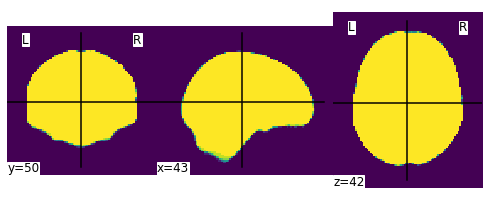

In [10]:
flat_mask_wThresh = nb.Nifti1Image(np.mean(huge_mask_wThreshold, 3), np.eye(4))
_ = plotting.plot_img(flat_mask_wThresh)

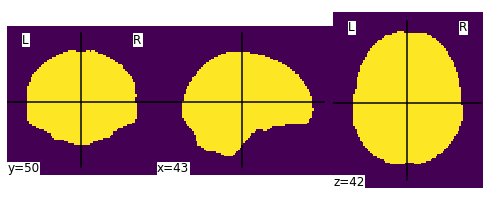

In [11]:
_ = plotting.plot_img(image.math_img("a>=%s" % str(1.0), a=flat_mask_wThresh))

2. average across all average (i.e. not binarized) task masks, threshold to voxels with value .95

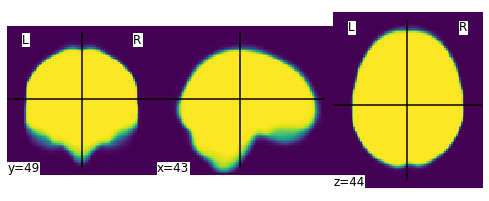

In [12]:
flat_mask_noThresh = nb.Nifti1Image(np.mean(huge_mask_noThreshold, 3), np.eye(4))
_ = plotting.plot_img(flat_mask_noThresh)

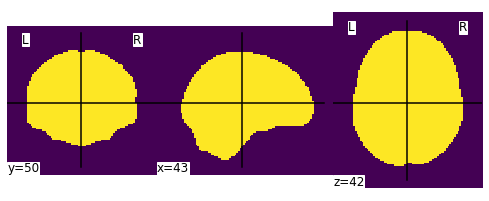

In [13]:
_ = plotting.plot_img(image.math_img("a>=%s" % str(.95), a=flat_mask_noThresh))

# Using masks from all tasks

In [14]:
masks = glob(path.join(FMRIPREP_DIR, 'sub-*/ses-*/func/*brain_mask.nii.gz'))
print(len(masks), 'masks found')
mean_mask = image.mean_img(masks)
mean_data = mean_mask.get_data()

1230 masks found


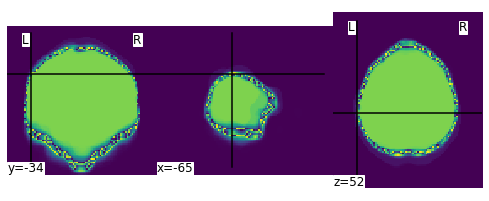

In [15]:
# UNTHRESHOLDED
_ = plotting.plot_img(mean_mask)

In [16]:
masks

['/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/fmriprep/sub-s518/ses-2/func/sub-s518_ses-2_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
 '/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/fmriprep/sub-s518/ses-2/func/sub-s518_ses-2_task-stopSignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
 '/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/fmriprep/sub-s518/ses-2/func/sub-s518_ses-2_task-twoByTwo_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
 '/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/fmriprep/sub-s518/ses-2/func/sub-s518_ses-2_task-ANT_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
 '/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/fmriprep/sub-s518/ses-2/func/sub-s518_ses-2_task-CCTHot_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
 '/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_sc

In [17]:
nanmasked_mean_data = np.where(mean_data==0, np.nan, mean_data)
np.nanmean(nanmasked_mean_data)

0.12129644866710247

In [18]:
np.nanmax(nanmasked_mean_data)

0.2073170731707317

In [19]:
np.nanmin(nanmasked_mean_data)

0.0008130081300813008

In [20]:
np.shape(mean_data)

(89, 105, 89)

/Users/henrymj/anaconda3/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:62: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  .format(DEFAULT_CUT_COORDS))


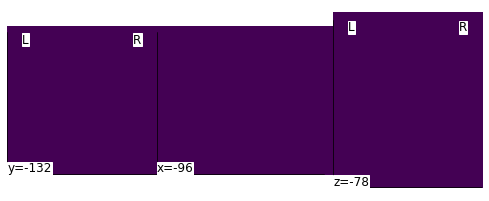

In [21]:
# NORMAL THRESHOLD
group_mask = image.math_img("a>=%s" % str(.95), a=mean_mask)
_ = plotting.plot_img(group_mask)

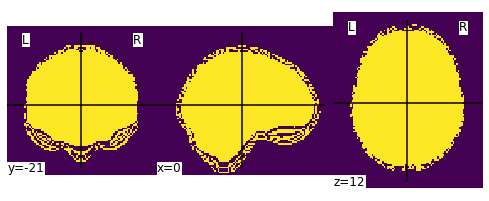

In [22]:
# LOW THRESHOLD
group_mask = image.math_img("a>=%s" % str(.1), a=mean_mask)
_ = plotting.plot_img(group_mask)

# OLD MASK

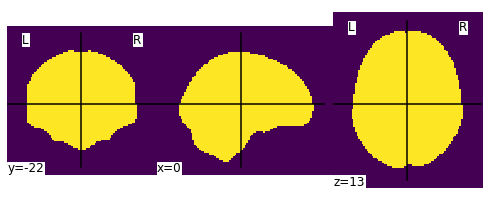

In [23]:
OLD_DIR = FMRIPREP_DIR.replace('fmriprep', '2ndlevel_4_14_20')
old_mask_path = path.join(OLD_DIR, 'group_mask_thresh-0.95.nii.gz')
old_mask = image.load_img(old_mask_path)
_ = plotting.plot_img(old_mask)

# Using a subset of masks

In [24]:
len(masks)/9

136.66666666666666

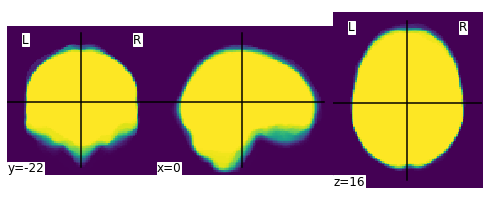

In [25]:
mean_mask = image.mean_img(masks[:136])
mean_data = mean_mask.get_data()
# UNTHRESHOLDED
_ = plotting.plot_img(mean_mask)

In [26]:
np.nanmean(np.where(mean_data==0, np.nan, mean_data))

0.8209128759248314

# USING OLD FMRIPREP

In [27]:
old_fmriprep_dir = FMRIPREP_DIR.replace('fmriprep', 'fmriprep_8_9_20')
old_fmriprep_dir

'/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/fmriprep_8_9_20'

In [28]:
masks = glob(path.join(old_fmriprep_dir, 'sub-*/ses-*/func/*brain_mask.nii.gz'))
print(len(masks), 'masks found')
mean_mask = image.mean_img(masks)
mean_data = mean_mask.get_data()

1233 masks found


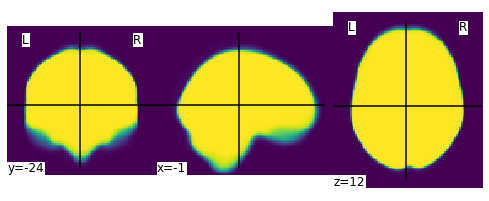

In [29]:
# UNTHRESHOLDED
_ = plotting.plot_img(mean_mask)

In [30]:
mean_data = mean_mask.get_data()
np.nanmean(np.where(mean_data==0, np.nan, mean_data))

0.6879027

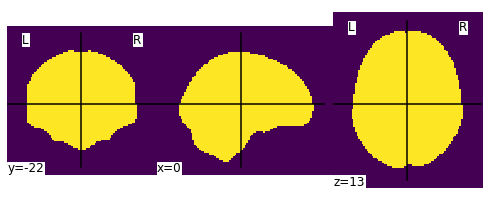

In [31]:
_ = plotting.plot_img(image.math_img("a>=%s" % str(.95), a=mean_mask))

# subsetting to using those same masks, but from the new fmriprep run

In [117]:
missing_masks = ['sub-s251_ses-2_task-motorSelectiveStop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s495_ses-1_task-ANT_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s495_ses-2_task-stroop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s554_ses-2_task-motorSelectiveStop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s574_ses-1_task-surveyMedley_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s591_ses-1_task-stroop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s601_ses-2_task-ANT_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s623_ses-3_task-stroop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s623_ses-4_task-stopSignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s629_ses-1_task-ANT_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s633_ses-1_task-stroop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s647_ses-1_task-ANT_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s649_ses-1_task-motorSelectiveStop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s649_ses-1_task-stroop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s649_ses-1_task-DPX_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s649_ses-1_task-discountFix_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s649_ses-1_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s649_ses-1_task-surveyMedley_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s649_ses-2_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s649_ses-2_task-twoByTwo_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s649_ses-2_task-WATT3_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s649_ses-3_task-ANT_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s649_ses-3_task-stopSignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 'sub-s649_ses-3_task-CCTHot_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                 ]


new_masks = [m.replace('fmriprep_8_9_20', 'fmriprep') for m in masks if not any(miss in m for miss in missing_masks)]
print(len(new_masks))

1209


In [118]:
mean_mask = image.mean_img(new_masks)
mean_data = mean_mask.get_data()

ValueError: File not found: '/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/fmriprep/sub-s518/ses-2/func/sub-s518_ses-2_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'

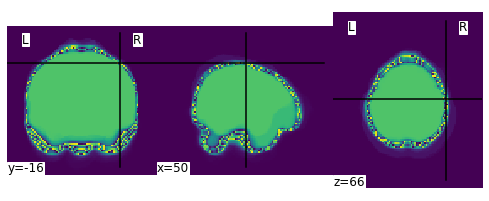

In [104]:
# UNTHRESHOLDED
_ = plotting.plot_img(mean_mask)

In [105]:
mean_data = mean_mask.get_data()
np.nanmean(np.where(mean_data==0, np.nan, mean_data))

0.11261103751837426

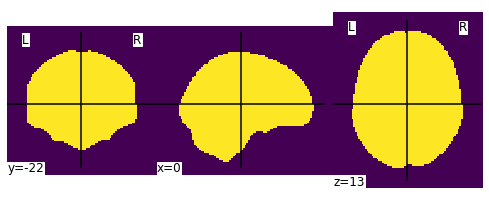

In [116]:
_ = plotting.plot_img(image.math_img("a>=%s" % str(.95), a=mean_mask))

# going back to old fmriprep since we dropped those 24 missing files

In [107]:
old_masks  = [m.replace('fmriprep', 'fmriprep_8_9_20') for m in new_masks]
print(len(old_masks))

1209


In [112]:
mean_mask = image.mean_img(old_masks)
mean_data = mean_mask.get_data()

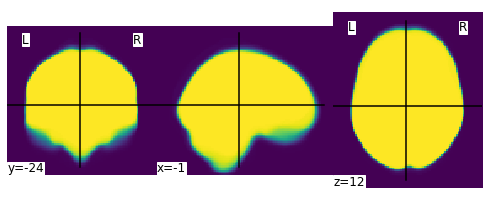

In [113]:
# UNTHRESHOLDED
_ = plotting.plot_img(mean_mask)

In [114]:
mean_data = mean_mask.get_data()
np.nanmean(np.where(mean_data==0, np.nan, mean_data))

0.6882929

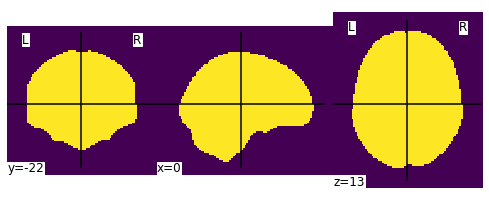

In [115]:
_ = plotting.plot_img(image.math_img("a>=%s" % str(.95), a=mean_mask))